# Generate Features drom Chemical Data

## Setup

In [1]:
import pyspark
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from matplotlib import cm

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
myAppName = "rezept-plots" #Nur kleine Buchstaben hier, at any cost
spark = pyspark.sql.SparkSession\
       .builder\
       .appName(myAppName)\
       .config("spark.kubernetes.executor.podNamePrefix", os.environ["POD_NAME"]+'-'+myAppName)\
       .config("spark.executor.cores", "4")\
        .config("spark.kubernetes.executor.request.cores", "0.1")\
       .config("spark.executor.memory", "4g")\
       .config("spark.driver.maxResultSize", "2g")\
       .config("spark.dynamicAllocation.maxExecutors", "10")\
       .config("spark.jars.packages", "")\
       .getOrCreate()

In [5]:
spark.stop()

## Load and manipulate Data

## Load already computed data

In [ ]:
pivoted = spark.read.parquet("/reif/test/pivoted.parquet")
input_cols = pivoted.drop("PulverBatchNr", "LNRREZMISCHER").columns
pulverBatchNr = pivoted.select("PulverBatchNr").toPandas()
pulverBatchNrList = pulverBatchNr.PulverBatchNr.to_list()

In [ ]:
pivoted.count()

In [ ]:
from pyspark.sql import Window

window_size = 300
spike_size = 4
my_window = Window.partitionBy(F.date_trunc("month", F.col("timestamp"))).orderBy(F.col("timestamp").cast("long")).rangeBetween(-window_size,0)
column = "Prozesswerte_PW_Vorerh_PLSR_Prozess_PW_17_Kommentar_Druck_vor_Vorerhitzung"


Spikes = {}
for i in [300, 301, 302, 303]:
    Machine = spark.read.parquet(f"/reif/01-data-corpus/{i}/completeLine/LineWithBatchNumbers.parquet")
    Spikes[str(i)] = Machine.select("timestamp", column, "RohwareInVE")\
        .withColumn("prev_min", F.min(column).over(my_window))\
        .withColumn("prev_max", F.max(column).over(my_window))\
        .withColumn("Spike", F.when((F.col(column) - F.col("prev_min") > 10*spike_size) | (F.col("prev_max") - F.col(column) > 10*spike_size), 1).otherwise(0))\
        .groupBy("RohwareInVE")\
            .agg(F.max("spike").alias("spike"), F.first("timestamp").alias("Start"), F.mean(column).alias("mean"), F.stddev(column).alias("stddev"))\
        .withColumn("Mischer", F.lit(i))
Spikes = Spikes["300"].unionByName(Spikes["301"]).unionByName(Spikes["302"]).unionByName(Spikes["303"]).cache()

In [ ]:
# If job for creating machine data will be restarted, you need to change variable from PulverBatchNr to RohwarenBatchNr
batchvalue = "PulverBatchNr"
corpusDf = pivoted\
    .join(Spikes,
          (F.col("LNRREZMISCHER") == F.col("Mischer")) &
          (F.col(batchvalue) == F.col("RohwareInVE")),
          "inner")\
    .select(batchvalue, *input_cols, "spike", "Start", "mean", "stddev")

In [4]:
corpusDf.groupBy("Spike").count().show()

NameError: name 'corpusDf' is not defined

In [12]:
%pip install sklearn

Processing /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e/sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached joblib-0.16.0-py3-none-any.whl (300 kB)
  Using cached scipy-1.5.2-cp37-cp37m-manylinux1_x86_64.whl (25.9 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached numpy-1.19.2-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
tensorflow 2.3.0 requires scipy==1.4.1, but you'll have scipy 1.5.2 which is incompatible.
mlflow 1.11.0 requires alembic<=1.4.1, but

In [13]:
%pip install tensorflow

  Using cached tensorflow-2.3.0-cp37-cp37m-manylinux2010_x86_64.whl (320.4 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached numpy-1.18.5-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
Processing /home/jovyan/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2/termcolor-1.1.0-py3-none-any.whl
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached absl_py-0.10.0-py3-none-any.whl (127 kB)
Processing /home/jovyan/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6/wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl
  Using cached tensorboard-2.3.0-py3-none-any.whl (6.8 MB)
  Using cached grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)

In [14]:
corpusDf_pd = corpusDf.toPandas()

In [15]:
cmap = cm.get_cmap('Spectral') 

<AxesSubplot:xlabel='Start'>

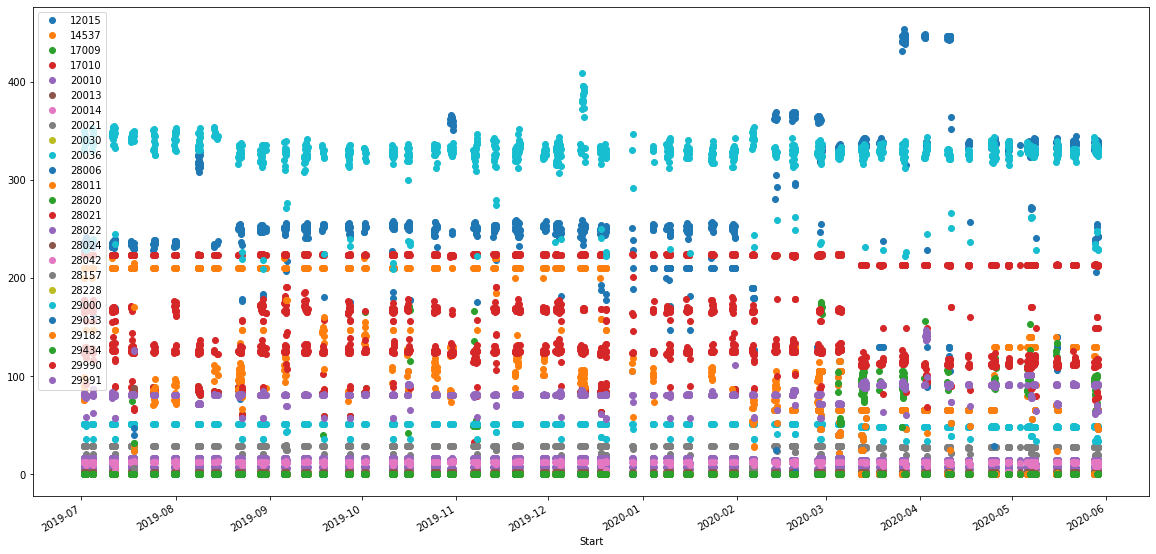

In [16]:
ingredients = corpusDf_pd.columns[2:-4]
fig1, ax1 = plt.subplots(figsize=(20,10))
corpusDf_pd.plot(x="Start", y=ingredients, ax=ax1, style="o")

In [17]:
ingredients

Index(['12015', '14537', '17009', '17010', '20010', '20013', '20014', '20021',
       '20030', '20036', '28006', '28011', '28020', '28021', '28022', '28024',
       '28042', '28157', '28228', '29000', '29033', '29182', '29434', '29990',
       '29991'],
      dtype='object')

In [18]:
corpusDf_pd["sum"] = corpusDf_pd[ingredients].sum(axis=1)

<AxesSubplot:xlabel='Start'>

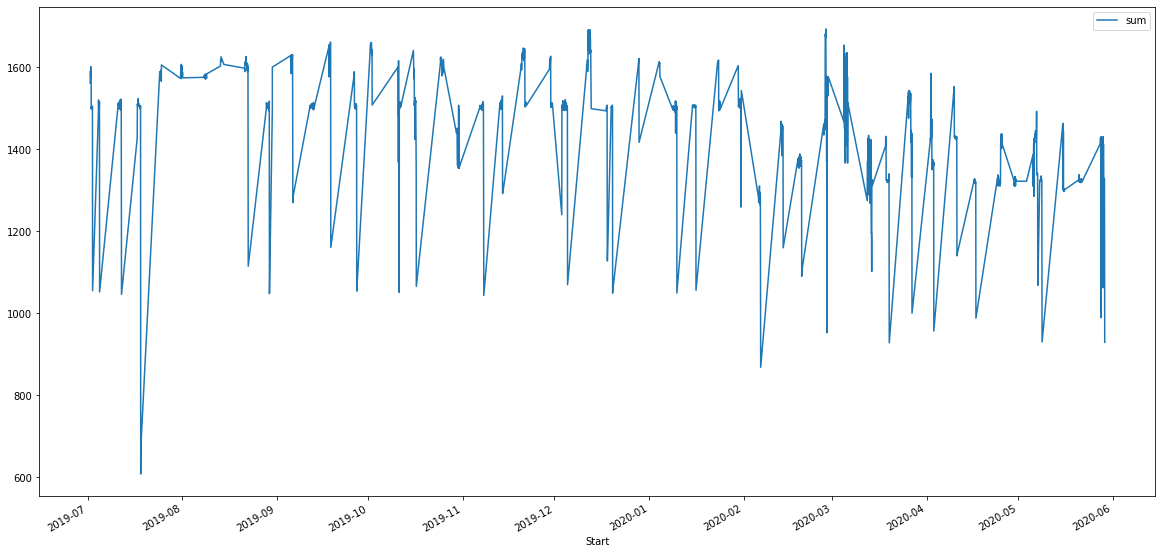

In [19]:
corpusDf_pd.plot(x="Start", y="sum")

<AxesSubplot:>

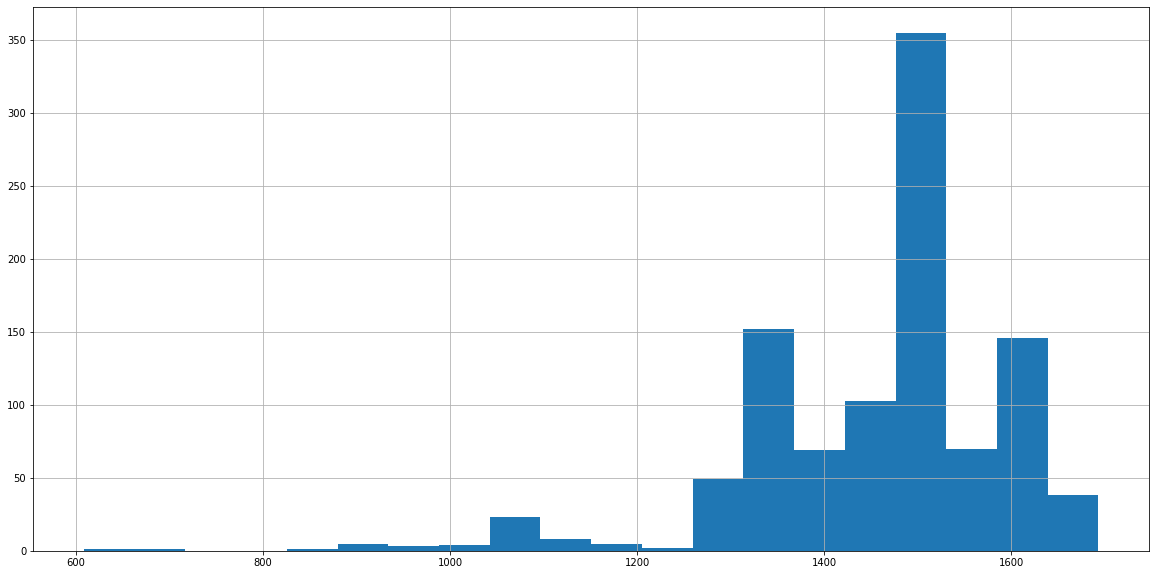

In [20]:
corpusDf_pd["sum"].hist(bins=20)

In [21]:
corpusDf_pd_new = corpusDf_pd[ingredients].div(corpusDf_pd["sum"], axis=0)
corpusDf_pd_new["Start"]=corpusDf_pd["Start"] 

<AxesSubplot:xlabel='Start'>

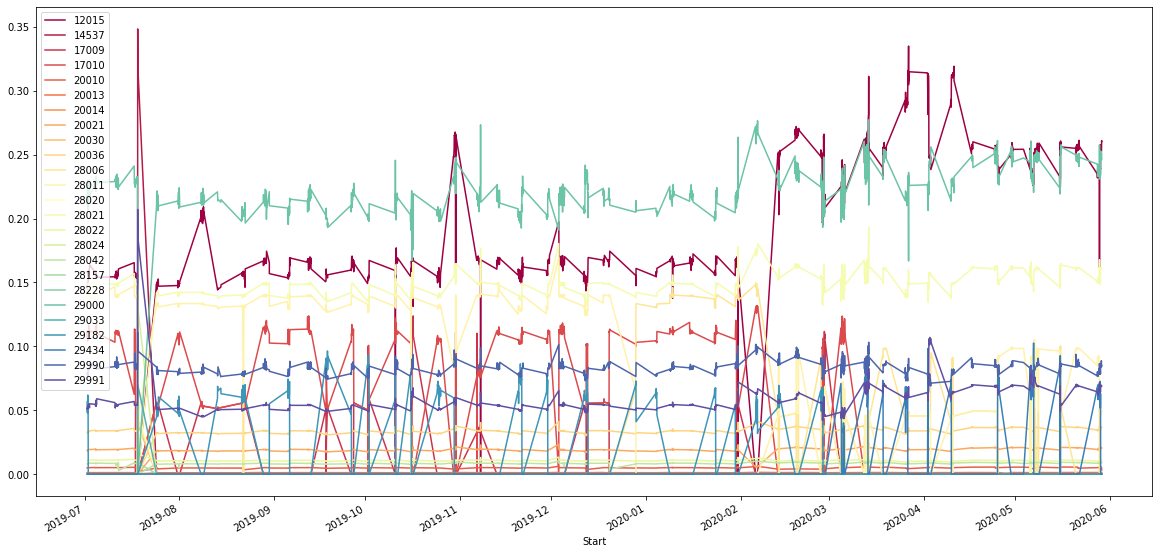

In [22]:
fig1, ax1 = plt.subplots(figsize=(20,10))
corpusDf_pd_new.plot(x="Start", y=ingredients, ax=ax1, cmap=cmap)


<AxesSubplot:xlabel='Start'>

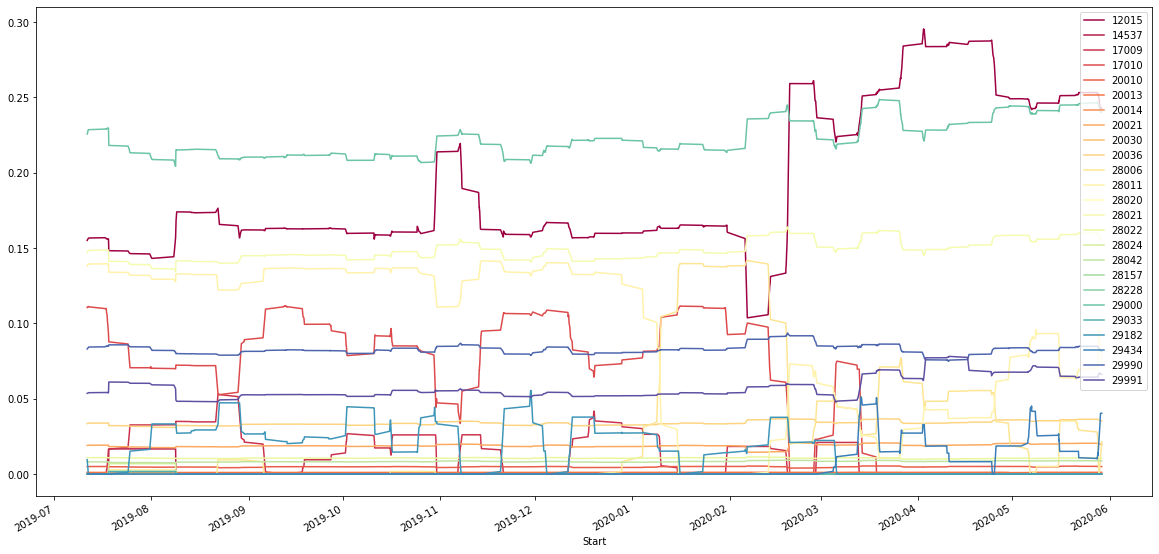

In [23]:
fig1, ax1 = plt.subplots(figsize=(20,10))

corpusDf_pd_mean = corpusDf_pd_new.sort_values("Start")[ingredients].rolling(window=40).mean()
corpusDf_pd_mean["Start"]=corpusDf_pd_new.sort_values("Start")["Start"]
corpusDf_pd_mean.plot(x="Start",y=ingredients, ax=ax1, cmap=cmap)

<AxesSubplot:xlabel='Start'>

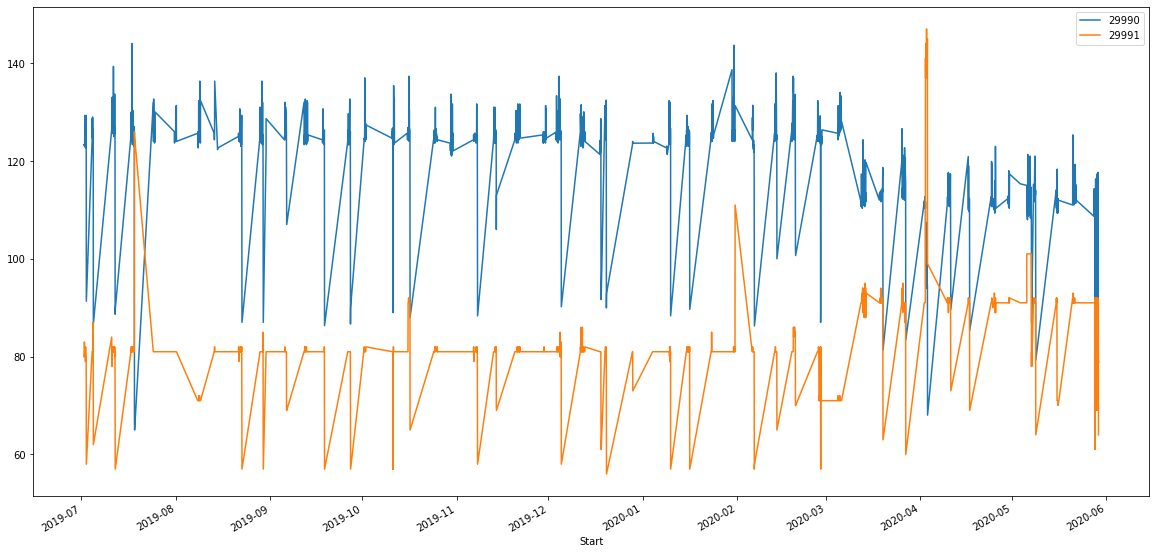

In [24]:
fig1, ax1 = plt.subplots(figsize=(20,10))
corpusDf_pd.plot(x="Start", y=["29990", "29991"], ax=ax1)


<AxesSubplot:xlabel='Start'>

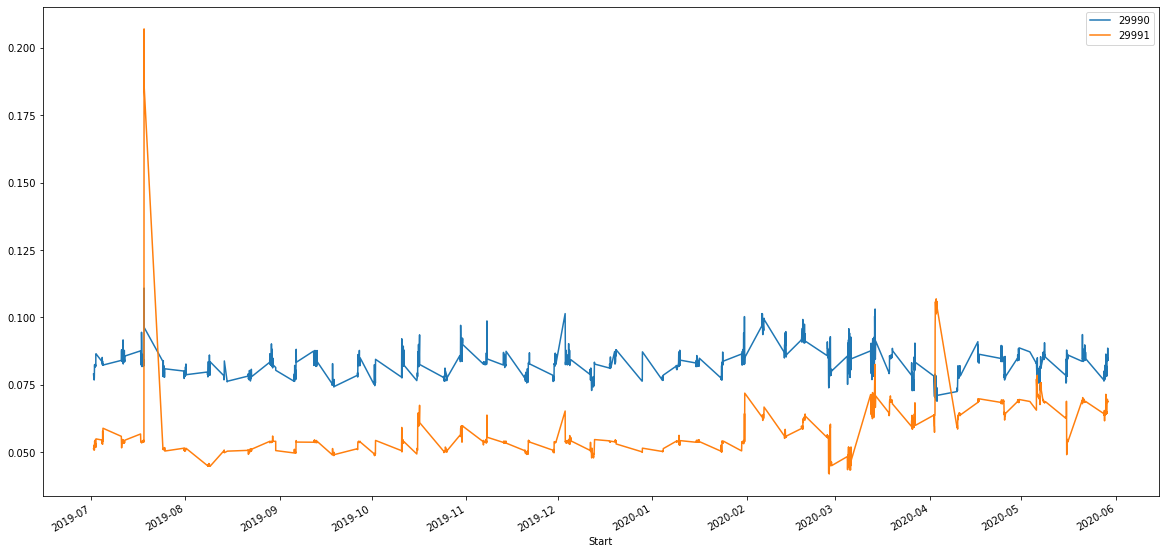

In [25]:
fig1, ax1 = plt.subplots(figsize=(20,10))
corpusDf_pd_new.plot(x="Start", y=["29990", "29991"], ax=ax1)
# corpusDf_pd.plot(x="Start", y=["mean","stddev"],ax=ax1,secondary_y=True )

## Recipe before and after 16.12.2019, and after 26.02.2020

In [26]:
corpusDf_pd_new["recipe"] = (corpusDf_pd_new.Start > "2020-02-26")*2 + ((corpusDf_pd_new.Start < "2020-02-26") & (corpusDf_pd_new.Start > "2019-12-16"))*1

In [27]:
import seaborn as sns
sns.barplot(x ="variable", y="value", hue="recipe", data=corpusDf_pd_new.groupby("recipe").mean().reset_index().melt(id_vars="recipe", value_vars=input_cols) )

KeyError: "The following 'value_vars' are not present in the DataFrame: ['12010']"

## Train model to predict standard deviation of pressure, with ingredients

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
corpusDf_pd_new = corpusDf_pd[input_cols].div(corpusDf_pd["sum"], axis=0)
features = corpusDf_pd_new[input_cols].values
labels = corpusDf_pd["stddev"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation='linear')
        ])
model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))#, class_weight = class_weights)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [ ]:
import numpy as np
import sklearn
y_pred = model.predict(X_test)
sklearn.metrics.mean_squared_error(y_pred, y_test)

In [ ]:
# naive vorhersage
sklearn.metrics.mean_squared_error(y_test, np.ones(np.size(y_test))*np.mean(y_test))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0, max_depth=3)
regressor.fit(X_train, y_train)

In [ ]:
y_dreg = regressor.predict(X_test)

In [ ]:
import sklearn
sklearn.metrics.mean_squared_error(y_dreg, y_test)

In [ ]:
sklearn.tree.plot_tree(regressor, feature_names = input_cols)

In [ ]:
for i in list(np.where(regressor.feature_importances_>0)[0]):
    print(input_cols[i] + " weight "+ str(regressor.feature_importances_[i]))